# MCMC Alt Approach

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import gpflow

from gpflow import default_float
from gpflow.ci_utils import ci_niter

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float

f64 = gpflow.utilities.to_default_float

In [2]:
def f(x):
    return 0.2 * x

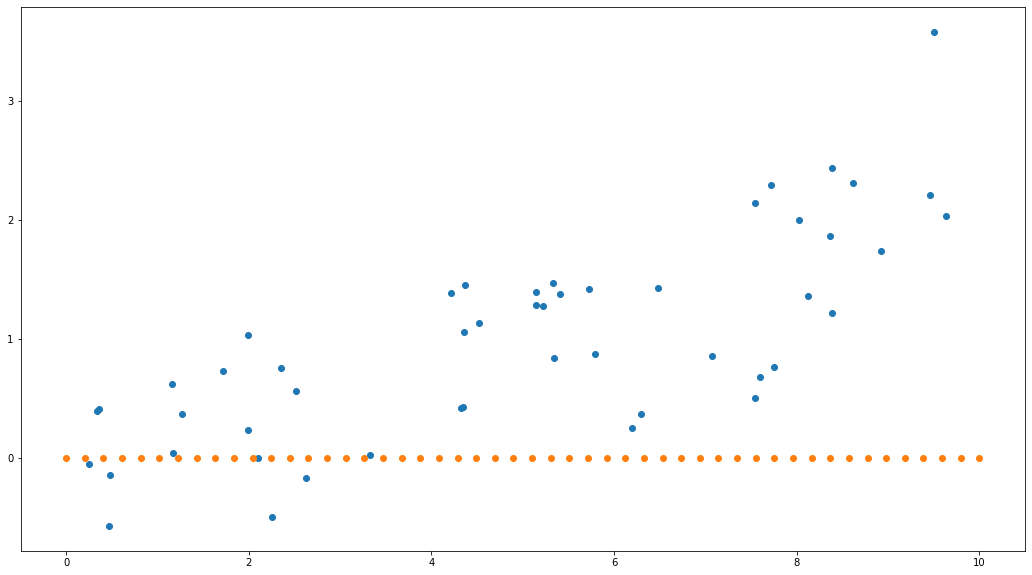

In [3]:
obs_noise = 0.5
num_points = 50
inducing = 50
Xrange = (0, 10)

X = np.random.uniform(Xrange[0], Xrange[1], (num_points, 1))
Z = np.linspace(Xrange[0], Xrange[1], inducing)[:, None]
Y = f(X) + np.random.normal(0., obs_noise, (num_points, 1))

plt.figure(figsize=(18, 10))
plt.scatter(X, Y)
plt.scatter(Z, [0 for i in Z])

data = (X, Y)

In [10]:
kernel = gpflow.kernels.Matern52()
likelihood = gpflow.likelihoods.Gaussian()
model = gpflow.models.SGPMC(data, kernel, likelihood, inducing_variable = Z)
model = gpflow.models.SGPR(data, kernel, inducing_variable = Z, noise_variance = 0.1)

In [11]:
model.kernel.lengthscales.assign(0.1)
model.kernel.variance.assign(0.1)

model.kernel.lengthscales.prior = tfd.Gamma(f64(0.1), f64(0.1))
model.kernel.variance.prior = tfd.Gamma(f64(0.1), f64(0.4))
model.likelihood.variance.prior = tfd.Gamma(f64(0.1), f64(0.1))

optimiser = gpflow.optimizers.Scipy()
maxiter = ci_niter(2000)
_ = optimiser.minimize(
    model.training_loss, model.trainable_variables, options=dict(maxiter=maxiter)
)

In [12]:
gpflow.utilities.set_trainable(model.inducing_variable.Z, False)

In [13]:
model

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.833949487687406
SGPR.kernel.lengthscales,Parameter,Softplus,Gamma,True,(),float64,2.2902495023488343
SGPR.likelihood.variance,Parameter,Softplus + Shift,Gamma,True,(),float64,0.2561914835412634
SGPR.inducing_variable.Z,Parameter,Identity,,False,"(50, 1)",float64,[[0.23607776...


In [53]:
num_burnin_steps = ci_niter(1000)
num_samples = ci_niter(6000)

hmc_helper = gpflow.optimizers.SamplingHelper(
    model.log_posterior_density, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=5, step_size=0.2
)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=1000, target_accept_prob=f64(0.9), adaptation_rate=0.02
)

@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        num_steps_between_results = 10,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )

samples, x = run_chain_fn()
parameter_samples = hmc_helper.convert_to_constrained_values(samples)

In [54]:
x

<tf.Tensor: shape=(6000,), dtype=bool, numpy=array([False, False, False, ...,  True,  True,  True])>

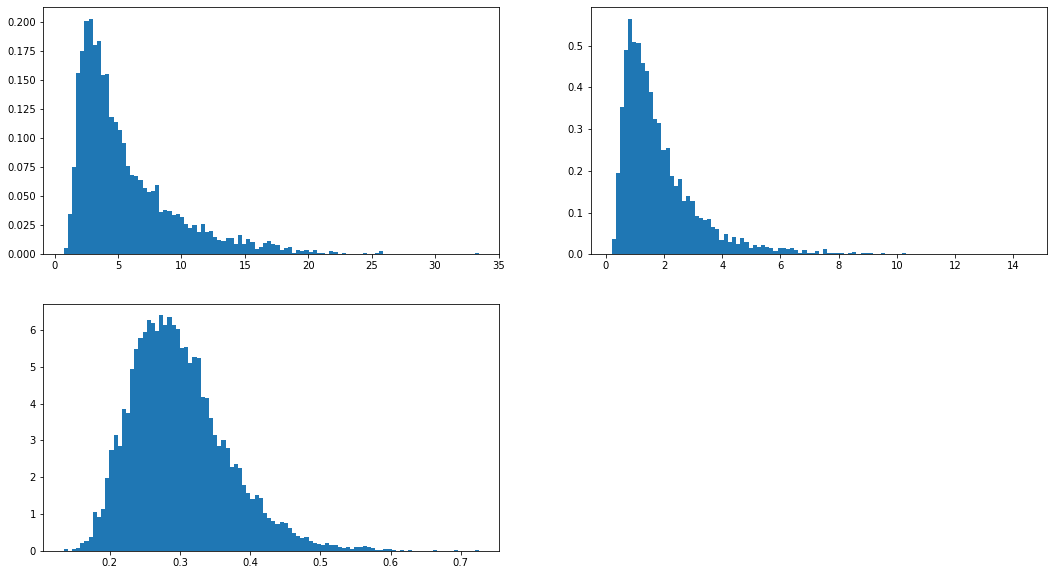

In [52]:
plt.figure(figsize = (18, 10))
plt.subplot(221)
plt.hist(parameter_samples[0].numpy(), 100, density=True)
plt.subplot(222)
plt.hist(parameter_samples[1].numpy(), 100, density=True)
plt.subplot(223)
plt.hist(parameter_samples[2].numpy(), 100, density=True);

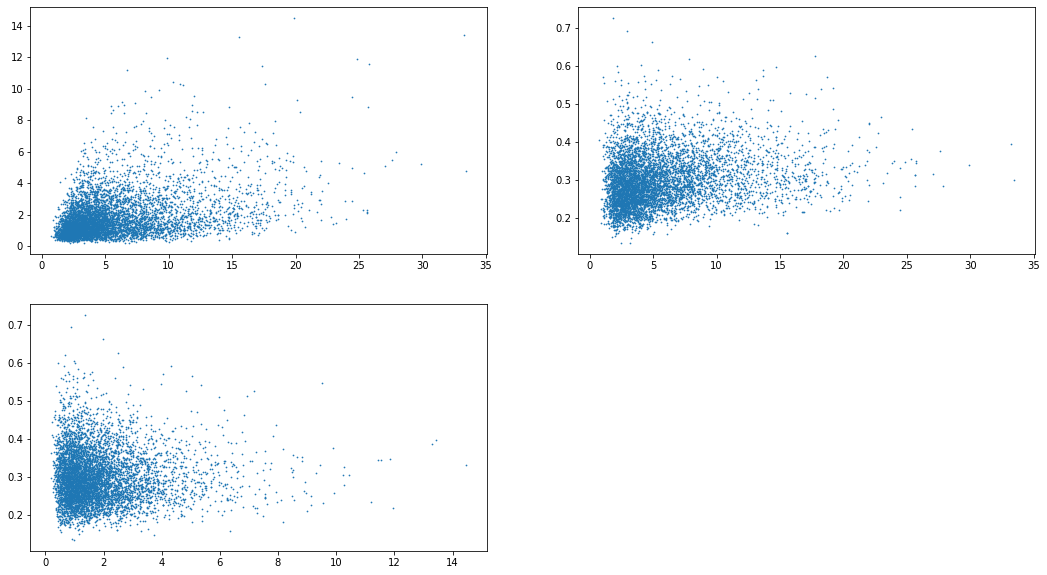

In [33]:
plt.figure(figsize = (18, 10))
plt.subplot(221)
plt.scatter(parameter_samples[0].numpy(), parameter_samples[1].numpy(), 0.5)
plt.subplot(222)
plt.scatter(parameter_samples[0].numpy(), parameter_samples[2].numpy(), 0.5)
plt.subplot(223)
plt.scatter(parameter_samples[1].numpy(), parameter_samples[2].numpy(), 0.5)

Had to play around with the priors and initialisations a lot to avoid the covariance converging to `inf` or `nan`.

In [37]:
Xtest = np.linspace(0, 10, 100)[:, None]
f_samples = []

for i in range(num_samples):
    # Note that hmc_helper.current_state contains the unconstrained variables
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f_batch = model.predict_f_samples(Xtest, 10)
    f_samples.append(f_batch)
f_samples = np.vstack(f_samples)

In [43]:
f_samples.shape

(60000, 100, 1)

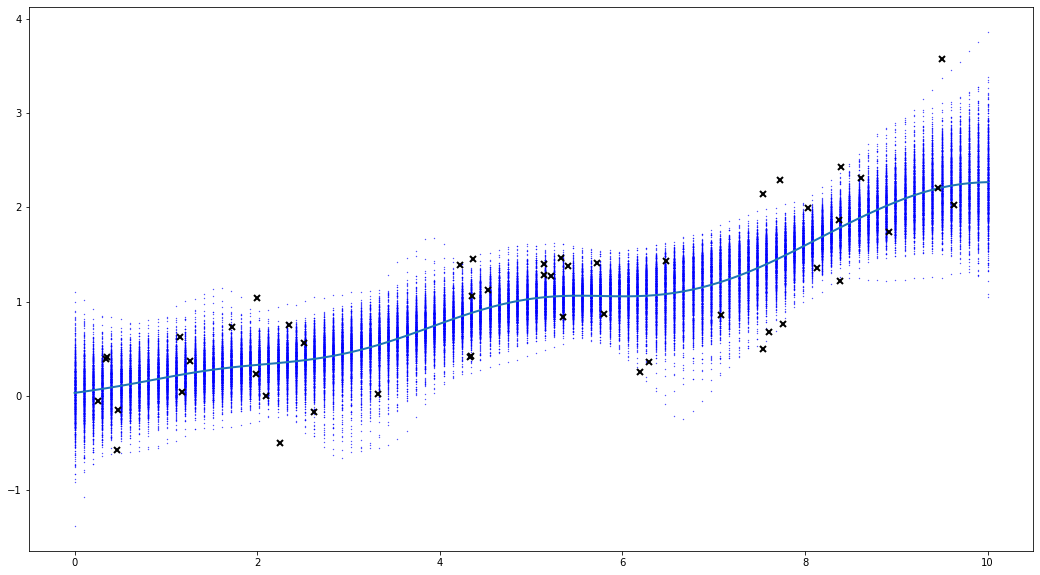

In [47]:
plt.figure(figsize=(18, 10))
(line,) = plt.plot(Xtest, np.mean(f_samples, 0), lw=2)
for i in range(1000):
    plt.scatter(Xtest, f_samples[i, :], 0.1, c = 'blue')
"""
plt.fill_between(
    Xtest[:, 0],
    np.percentile(np.squeeze(f_samples), 5, axis=0),
    np.percentile(np.squeeze(f_samples), 95, axis=0),
    color=line.get_color(),
    alpha=0.2,
)
"""
plt.plot(X.flatten(), Y.flatten(), "kx", mew=2)